In [102]:
# specify an ansatz over the 8 3-wave interaction terms

from quantum_logical.interaction import ConversionGainInteraction
import numpy as np
import itertools
from qutip import tensor, destroy
from quantum_logical.operators import (
    selective_destroy,
    reduce_to_two_qubit_subspace,
)
from weylchamber import c1c2c3, g1g2g3, WeylChamber
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from qutip import tensor
from quantum_logical.operators import _qutrit_to_3coords

In [28]:
transmon_levels = 3
a_ge = selective_destroy(transmon_levels, 1, 0)
a_ef = selective_destroy(transmon_levels, 2, 1)
a_gf = selective_destroy(transmon_levels, 2, 0)

operators_3wave = [
    tensor(a_ge, a_ge),  # a_ge b_ge, 0
    tensor(a_ge, a_ge.dag()),  # a_ge b_ge†, 1
    tensor(a_ef, a_ge),  # a_ef b_ge, 2
    tensor(a_ef, a_ge.dag()),  # a_ef b_ge†, 3
    tensor(a_ge, a_ef),  # a_ge b_ef, 4
    tensor(a_ge, a_ef.dag()),  # a_ge b_ef†, 5
    tensor(a_ef, a_ef),  # a_ef b_ef, 6
    tensor(a_ef, a_ef.dag()),  # a_ef b_ef†, 7
]

In [101]:
def _unitary(coefficients, t=1.0):
    assert len(coefficients) == len(operators_3wave)

    H = ConversionGainInteraction.from_coeff_ops_list(coefficients, operators_3wave)

    return H.construct_U(t=t)


u_gef = _unitary([1, 1, 1, 1, 1, 1, 1, 1])
_qutrit_to_3coords(u_gef)

((0.5, 0.31830989, 0.31830989), (0.5, 0.31830989, 0.31830989), (0.5, 0.0, 0.0))

In [30]:
from scipy.optimize import minimize
from numpy.linalg import norm


def unitary_objective(coefficients, target_gf=(0.5, 0.5, 0.5), weights=(1, 1, 1)):
    # Construct the unitary matrix using the provided coefficients
    u_gef = _unitary(coefficients)

    # Extract the Weyl chamber coordinates for each subspace
    coords_ge, coords_ef, coords_gf = _qutrit_to_3coords(u_gef)

    # Calculate the distance of ge and ef from the origin
    dist_ge = norm(coords_ge)
    dist_ef = norm(coords_ef)

    # If a target is given for gf, calculate the distance from that target,
    # otherwise just ensure it's non-zero (or penalize closeness to zero)
    if target_gf is not None:
        dist_gf = norm(np.array(coords_gf) - np.array(target_gf))
    else:
        # This encourages the gf gate to be away from zero without a specific target
        dist_gf = -norm(coords_gf) if norm(coords_gf) < 1e-3 else 0

    # Combine the objectives with weights, if needed
    combined_objective = (
        weights[0] * dist_ge + weights[1] * dist_ef + weights[2] * dist_gf
    )

    return combined_objective

In [96]:
initial_guess = np.random.rand(8)  # or some other starting point
result = minimize(unitary_objective, initial_guess, method="BFGS")
print(result)
ret_coeffs = result.x

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.8660254037844386
        x: [ 3.912e-02  3.940e-01  5.536e-01  2.287e-01  5.250e-01
             4.051e-01  6.691e-01  7.267e-01]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 9
     njev: 1


In [100]:
u_gef = _unitary(ret_coeffs, t=1.0)
coords_ge, coords_ef, coords_gf = _qutrit_to_3coords(u_gef)
print(coords_ge, coords_ef, coords_gf)
u_gef

(0.13309439, 0.10624178, 0.0) (0.45433617, 0.0199047, 0.0) (0.0, 0.0, 0.0)


Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.99927622+0.j          0.        +0.j         -0.00749351+0.j
   0.        +0.j          0.        -0.03492508j  0.        +0.j
  -0.00423141+0.j          0.        +0.j         -0.01237795+0.j        ]
 [ 0.        +0.j          0.80633462+0.j          0.        +0.j
   0.        -0.31553208j  0.        +0.j          0.        -0.42145057j
   0.        +0.j         -0.2695244 +0.j          0.        +0.j        ]
 [-0.00749351+0.j          0.        +0.j          0.92241729+0.j
   0.        +0.j          0.        -0.36159061j  0.        +0.j
  -0.04380918+0.j          0.        +0.j         -0.12815292+0.j        ]
 [ 0.        +0.j          0.        -0.31553208j  0.        +0.j
   0.79248019+0.j          0.        +0.j         -0.27379808+0.j
   0.        +0.j          0.        -0.44435264j  0.        +0.j        ]
 [ 0.        -0.03492508j  0.        +0.j          0.        -0.361

In [33]:
# Initialize Weyl chamber plot
weyl_chamber = WeylChamber()


def cartan_trajectory_qubit(c1c2c3_coordinates, marker_shape, label, time_steps):
    """
    Visualize the Cartan (Weyl chamber) trajectory of a qubit gate over time.
    Args:
        c1c2c3_coordinates: A list of tuples containing the (c1, c2, c3) coordinates for the trajectory.
        marker_shape: The shape of the marker to use in the plot.
        label: The label for the trajectory in the legend.
        time_steps: A sequence of time values for the trajectory.
    """

    # Map time steps to colormap
    cmap = plt.colormaps["viridis"]
    colors = cmap(np.linspace(0, 1, len(time_steps)))

    # Unpack coordinates
    c1_coords, c2_coords, c3_coords = zip(*c1c2c3_coordinates)

    # Scatter plot for the trajectory with the specified marker shape and color indicating time evolution
    weyl_chamber.scatter(
        c1_coords,
        c2_coords,
        c3_coords,
        c=colors,
        marker=marker_shape,
        label=label,
        s=50,
        depthshade=False,
    )


def cartan_trajectory_qutrit(coefficients, time_steps):
    """
    Visualize the Cartan trajectory of qutrit sub-gates (ge), (ef), and (gf) over time.
    """
    # Loop over each time step to get coordinates for each subspace
    ge_coords = []
    ef_coords = []
    gf_coords = []
    for t in time_steps:
        u_gef = _unitary(coefficients, t)
        coords_ge, coords_ef, coords_gf = _qutrit_to_3coords(u_gef)
        ge_coords.append(coords_ge)
        ef_coords.append(coords_ef)
        gf_coords.append(coords_gf)

    # Plot trajectories for each subspace
    cartan_trajectory_qubit(ge_coords, "o", "ge", time_steps)
    cartan_trajectory_qubit(ef_coords, "^", "ef", time_steps)
    cartan_trajectory_qubit(gf_coords, "s", "gf", time_steps)

    # Generate and show the plot
    fig = weyl_chamber.plot()
    plt.legend()
    plt.show()

    return fig

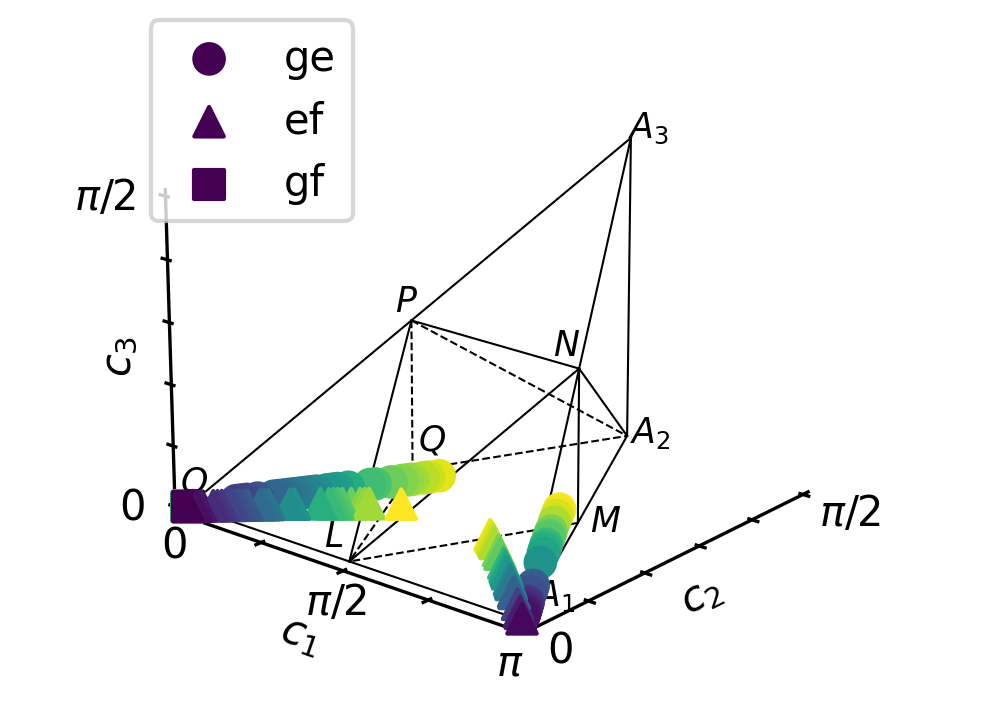

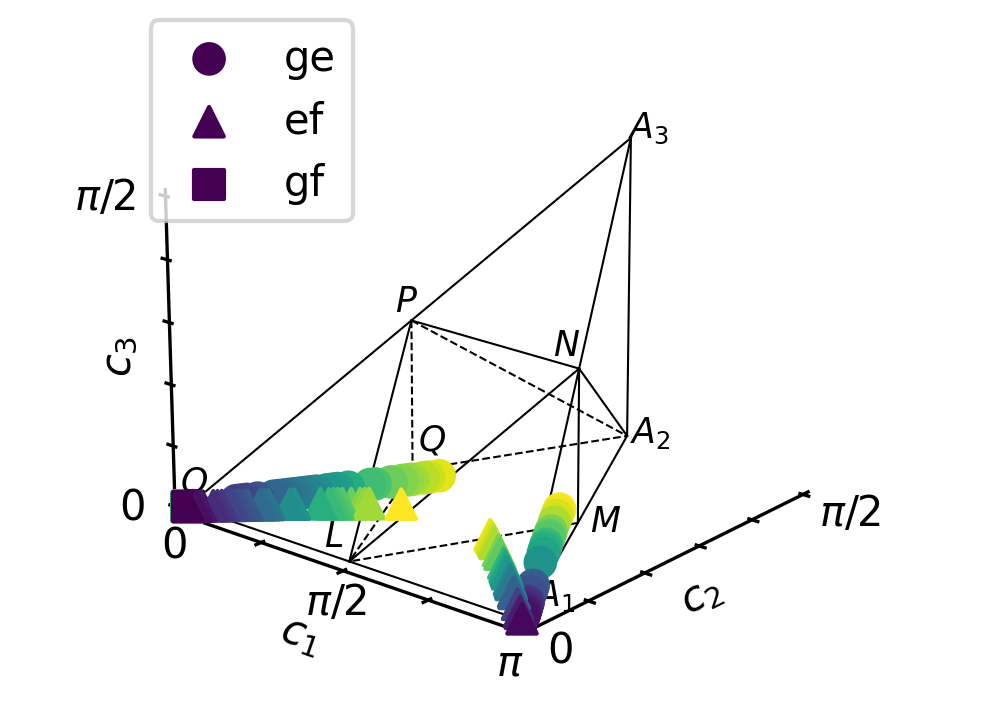

In [34]:
%matplotlib widget
# Define the time steps over which you want to plot the trajectory
time_steps = np.linspace(0, 1, 50)  # for example, 100 time steps from 0 to 1

# Use the coefficients from the optimization result
optimal_coefficients = result.x

# Call the function to plot the trajectory
fig = cartan_trajectory_qutrit(optimal_coefficients, time_steps)

# Show the result (if not done within the function)
plt.show();